### Special Topic: Feature Selection Methods
<b> Massey University </b>
<br><b> Author: Frederick Tan </b>
<br><b> Student Number: 16227617 </b>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as py
import seaborn as sns
import json

from matplotlib import colors as mcolors
from pylab import rcParams
from sklearn.decomposition import PCA

%matplotlib inline
sns.set(style="ticks")
matplotlib.style.use('ggplot')

# Cleanup Functions

In [2]:
def generate_fs_algo_descriptive_names(fs_algo):
    fs_algo_count = len(fs_algo)
    for i in range(fs_algo_count):
        for j in range(i, fs_algo_count):
            if j != i:
                fs_algo.append(fs_algo[i] + '+' + fs_algo[j])
    fs_algo.append('Multi')
    fs_algo.append('Union')
    fs_algo.append('Inter')
    return fs_algo

In [3]:
def up_sample_missing_th(df):
    for name in df.name.unique():
        last_df_with_value = pd.DataFrame()
        for i in range(20, 0, -1):
            th = (float(i) * 5) / 100
            if len(df[(df.name == name) & (df.feat_th == th)]) == 0:
                last_df_with_value['feat_th'] = th
                df = df.append(last_df_with_value)
                df.reset_index()
            else:
                last_df_with_value = df[(df.name == name) & (df.feat_th == th)].reset_index(drop=True)
    return df

In [4]:
def process_and_prepare_the_execution_time_table(exec_time_folder):
    exec_time_df = pd.DataFrame(columns=['name', 'exec_t_chi2', 'exec_t_lda', 'exec_t_ig', 'exec_t_rfe'])
    for fn in os.listdir(exec_time_folder):
        exec_time_fn = exec_time_folder + '/' + fn
        if not os.path.isfile(exec_time_fn):
            continue
        elif exec_time_fn == '.ipynb_checkpoints':
            continue
        dataset_name = fn.split('_fs')[0]
        df_t = pd.read_csv(exec_time_fn, header=None)
        df_t = df_t.transpose()
        df_t['name'] = dataset_name
        columns = list(df_t.columns)
        columns.pop(columns.index('name'))
        df_t = df_t[['name'] + columns]
        df_t = df_t.rename(columns={0:'exec_t_chi2', 1:'exec_t_lda', 2:'exec_t_ig', 3:'exec_t_rfe'})
        exec_time_df = exec_time_df.append(df_t)
    return exec_time_df

In [5]:
def build_dataset_dataframe_representation(json_Config_file, exec_time_folder):
    datasets_file = open(json_Config_file)
    datasets_json = json.load(datasets_file)
    datasets_file.close()
    datasets = datasets_json['datasets']
    dataset_df = pd.DataFrame(columns = {'name', 'instances', 'attr_cnt', 'attr_types', 'classes_cnt'})
    keys = ''
    for dataset in datasets:
        df_t = pd.DataFrame({'name': dataset['filename'].split('.')[0],
                                'instances': dataset['instances'],
                                'attr_cnt': dataset['attribute']['count'],
                                'attr_types': [dataset['attribute']['characteristics']],
                                'classes_cnt': dataset['num_classes']
                                })
        dataset_df = dataset_df.append(df_t, ignore_index=True)

    dataset_df.name = dataset_df.name.apply(lambda x: x.split('_cleaned')[0])

    dataset_df = dataset_df.join(pd.get_dummies(dataset_df['attr_types'], prefix='attr_type'))
    dataset_df['attr_type_real'] = dataset_df['attr_type_integer, real']
    dataset_df['attr_type_integer'] = dataset_df['attr_type_integer, real'] + dataset_df['attr_type_integer']

    dataset_df.drop(['attr_types', 'attr_type_integer, real'], axis=1, inplace=True)
    columns = list(dataset_df.columns.values)
    columns.pop(columns.index('name'))
    dataset_df = dataset_df[['name'] + columns]
    execution_time_df = process_and_prepare_the_execution_time_table(exec_time_folder)
    dataset_df = pd.merge(dataset_df, execution_time_df, on='name')
    # Ensure the features are numbers
    dataset_df.attr_cnt = dataset_df.attr_cnt.astype('int')
    dataset_df.classes_cnt = dataset_df.classes_cnt.astype('int')
    dataset_df.instances = dataset_df.instances.astype('int')
    dataset_df.attr_type_integer = dataset_df.attr_type_integer.astype('int')
    return dataset_df

In [6]:
def process_and_clean_up_the_result(results_dir):
    fs_algo = []
    fs_algo_filled = False
    results_df = pd.DataFrame()
    results_folder = results_dir
    filenames = []
    for dataset_name in os.listdir(results_folder):
        dataset_folder = results_folder + '/' + dataset_name
        if os.path.isdir(dataset_folder) == False:
            continue
        elif dataset_folder == '.ipynb_checkpoints':
            continue
        for fn in os.listdir(dataset_folder):
            filename = dataset_folder + '/' + fn
            if os.path.isfile(filename) == False:
                continue
            df_t = pd.read_csv(filename)
            filenames.append(filename)
            df_t['name'] = dataset_name.split('_cleaned')[0]
            results_df = results_df.append(df_t)
            fn_split = fn.split('_')
            if fs_algo_filled == False:
                fs_algo.append(fn_split[0])
                fs_algo.append(fn_split[1])
                fs_algo.append(fn_split[2])
                fs_algo.append(fn_split[3])
                fs_algo_filled = True

    fs_algo = generate_fs_algo_descriptive_names(fs_algo)
    results_df = results_df.drop('fold_id', axis=1).drop('Unnamed: 0', axis=1)
    results_df = results_df.rename(columns={'geo_score':'geo_score_woz', 'geo_score_woz':'real_geo_score'})
    results_df = results_df.rename(columns={'score':'accuracy_score'})
    columns = list(results_df.columns)
    columns.pop(columns.index('exec_t'))
    columns.pop(columns.index('name'))
    results_df = results_df[['name'] + columns + ['exec_t']]
    results_df['feat_set_id'] = results_df['feat_set_id'].apply(lambda x: fs_algo[x])
    return up_sample_missing_th(results_df)

In [117]:
def rank_by_classifier(classifier):
    #df_t = results_df[results_df['classifier'] == classifier].drop('feat_th', axis = 1).groupby(['feat_set_id']).mean().reset_index()
    df_t = results_df[results_df['classifier'] == classifier].groupby(['feat_set_id']).mean().reset_index()
    df_t['rank_by_score'] = df_t['accuracy_score'].rank(ascending=False)
    df_t.drop(['geo_score_woz', 'real_geo_score', 'exec_t', 'accuracy_score'], axis = 1, inplace=True)
    return df_t

In [8]:
colors = ['indigo', 'firebrick', 'darkolivegreen', 'papayawhip', 'darkturquoise', 'cadetblue', 'magenta', 'darksalmon', 'azure',
         'palevioletred', 'mediumspringgreen', 'mistyrose', 'darkviolet']

In [118]:
def generate_df_rank_per_classifier(results_df):
    classifiers = results_df.classifier.unique()
    df_rank_per_classifier = pd.DataFrame()
    for classifier in classifiers:
        df_t = rank_by_classifier(classifier)
        df_t.rename(columns={'rank_by_score':'rank_' + classifier}, inplace=True)
        if df_rank_per_classifier.empty:
            df_rank_per_classifier = df_t
        else:
            df_rank_per_classifier = pd.merge(df_rank_per_classifier, df_t)
    return df_rank_per_classifier

In [37]:
def boxplot_df(df_param):
    columns_to_plot = list(df_param.columns)
    _ = columns_to_plot.pop(columns_to_plot.index('feat_set_id'))
    for index, column in zip(range(len(columns_to_plot)), columns_to_plot):
        plt.boxplot('feat_set_id', column, data=df_param)

    plt.rcParams['figure.figsize'] = (20, 8)
    plt.legend()

In [10]:
def plot_df(df_param):
    columns_to_plot = list(df_param.columns)
    _ = columns_to_plot.pop(columns_to_plot.index('feat_set_id'))
    for index, column in zip(range(len(columns_to_plot)), columns_to_plot):
        plt.plot('feat_set_id', column, data=df_param, marker='o', color=colors[index], linewidth=1)

    plt.rcParams['figure.figsize'] = (20, 8)
    plt.legend()

In [112]:
def display_feature_sets(title):
    circle1 = plt.Circle((0.6, 0.45), 0.2, color='r', alpha=0.5)
    circle2 = plt.Circle((0.4, 0.45), 0.2, color='blue', alpha=0.5)
    circle3 = plt.Circle((0.4, 0.65), 0.2, color='g', alpha=0.5)
    circle4 = plt.Circle((0.6, 0.65), 0.2, color='y', alpha=0.5)
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax = plt.subplots()
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.add_artist(circle4)
    plt.title(title)
    ax.legend([circle3, circle4, circle2, circle1], ['chi2', 'lda', 'ig', 'rfe'])

In [12]:
def display_accuracy_score_table(dataset_df, results_df):
    results_accuracy_score_by_ds = pd.DataFrame()
    results_rank_by_ds = pd.DataFrame()
    results_df_t = results_df.copy()
    dataset_df_t = dataset_df.copy()
    appended_columns = list(results_df_t['feat_set_id'].unique())
    for name in np.sort(results_df.name.unique()):
        results_rank = results_df[results_df['name'] == name].groupby('feat_set_id').mean().accuracy_score.rank(ascending=False)
        results_rank = results_rank.reset_index().set_index('feat_set_id')
        results_rank = pd.DataFrame(results_rank.transpose())
        results_rank = results_rank.reset_index(drop=True)
        columns = list(results_rank.columns)
        results_rank['name'] = name
        results_rank = results_rank[['name'] + columns]
        results_rank_by_ds = results_rank_by_ds.append(results_rank)

        results_acc_score = results_df[results_df['name'] == name].groupby('feat_set_id').mean().accuracy_score#.rank(ascending=False)
        results_acc_score = results_acc_score.reset_index().set_index('feat_set_id')
        results_acc_score = pd.DataFrame(results_acc_score.transpose())
        results_acc_score = results_acc_score.reset_index(drop=True)
        columns = list(results_acc_score.columns)
        results_acc_score['name'] = name
        results_acc_score = results_acc_score[['name'] + columns]
        results_accuracy_score_by_ds = results_accuracy_score_by_ds.append(results_acc_score)

    results_rank_by_ds = pd.DataFrame(results_rank_by_ds.mean())
    results_rank_by_ds = results_rank_by_ds.transpose()
    results_accuracy_score_by_ds = pd.merge(dataset_df, results_accuracy_score_by_ds, on='name')
    results_accuracy_score_by_ds = results_accuracy_score_by_ds.set_index('name')
    results_accuracy_score_by_ds.index.name = None
    #columns_to_delete = ['attr_cnt', 'classes_cnt', 'instances', u'attr_type_integer', 'attr_type_real', 
    #                     'exec_t_chi2', 'exec_t_lda', 'exec_t_ig', 'exec_t_rfe']
    #results_accuracy_score_by_ds = results_accuracy_score_by_ds.drop(columns_to_delete, axis=1)
    results_accuracy_score_by_ds = results_accuracy_score_by_ds.append(results_rank_by_ds)
    results_accuracy_score_by_ds = results_accuracy_score_by_ds.rename(index={0:'mean_rank'})
    return results_accuracy_score_by_ds

In [13]:
dataset_df = build_dataset_dataframe_representation('./datasets_v05.json', './exec_time_5.0')
results_df = process_and_clean_up_the_result('./results_5.0')

In [14]:
#results_df = results_df[results_df.feat_set_id != 'Union'].reset_index(drop=True)

results_df_control = process_and_clean_up_the_result('./results_5.3')
results_df_control['feat_set_id'] = 'control'

results_df = results_df.append(results_df_control).reset_index(drop=True)

# Introduction

There are two objectives in this study:
<ul>
    <li> Replicate the result of a similar study conducted, namely, "Wisdom of Crowds: An Empirical Study
of Ensemble-Based Feature Selection Strategies (Susnjak, et. al.)" and extend the experiment</li>
    <li> Investigate the relationship between the feature selection ranking and accuracy score versus the different characteristics of the dataset</li>
</ul>

## Replicating and Extending the "Wisdom of Crowds"

In the "Wisdom of Crowds", the researchers conducted an experiment over nine datasets. In this study, the author manages to download and to run the experiment on six of these datasets.

These datasets are: Waveform, Fac profile, Fourier, Karhunen-Love, Pixel avg, Zernike Moments.

To extend the research done, in addition to the original feature selection algorithms used a wrapper method was introduced. The wrapper method chosen is Recursive Feature Elimination (RFE) using Linear SVR as the estimator. This is one of the most common wrapper methods for feature selection, and thus was selected.

The other three feature selection algorithms -- chi2, lda, rfe -- were kept.

## Feature Set Selection

The different feature sets were generated through the combination of the four feature selection algorithms. Figure 1 below tries to illustrate this combination.

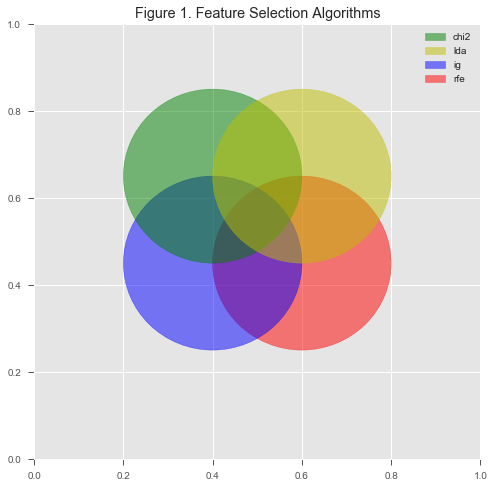

In [113]:
display_feature_sets('Figure 1. Feature Selection Algorithms')

<img src="images/multi.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;" >
<img src="images/all-intersection.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;" >
<img src="images/pair.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;" >

Above, counter-clockwise: Union, Multi, All-Intersection, Pair (e.g. LDA + IG)

## Test Setup

The test process consists of (1) Cleaning the datasets, (2) Generating the dataset schema, (3) Running the Linux script/application to process the datasets, and (4) Analysing the results

The test setup is described in the figure below:
![alt text](images/FSRankerApplication.png "Application")

## Dataset Properties

In [16]:
columns_to_display = ['name', 'attr_cnt', 'classes_cnt', 'instances']
df_t = dataset_df[columns_to_display].rename(columns={'attr_cnt':'features', 'classes_cnt':'classes'})
df_t.sort_values('instances', ascending=True).reset_index(drop=True)

name  features  classes  instances
0                  wine        13        3        178
1          vertebral_3C         6        4        314
2           dermatology        93        6        358
3         breast_tissue        14      105        421
4            arrhythmia       279       14        459
5               dresses       657        3        497
6         balance_scale         6        5        625
7       cervical_cancer        30       13        674
8        contraceptives         9        3       1473
9                 yeast         8       10       1484
10                  car        21        4       1728
11   benzos_consumption        12        7       1885
12          fac_profile       216       10       2000
13              zernike        47       10       2000
14             karhunen        64       10       2000
15              fourier        76       10       2000
16                pixel       240       10       2000
17     cardiotocography        35        3       2126
18              abalone        10       28       4198
19          waveform_v2        40        3       5000
20          waveform_v1        21        3       5000
21             mushroom       101        6       5644
22         wine_quality        11        7       6497
23              eeg_eye        14        2      14980
24            occupancy         5        2      20560
25  credit_card_default        23        2      30000
26     sensorless_drive        48       12      58513

There are 27 datasets used for the analysis. The objective was to use as varied datasets as possible.
The dataframe (dataset_df) above describes these datasets in terms of the features -- count (attr_cnt), integer (attr_type_integer), real (attr_type_real), the number of classes (classes_cnt), and the number of instances (instances). Do note that this is the description after cleaning the datasets. The description of the raw datasets is maintained in this google docs: https://docs.google.com/spreadsheets/d/1vNRjXj12O25Oni2EU1tSBfIZNfwv-zI2vxeprYBipgc/edit#gid=0.

Some of the methods used to clean the dataset up include the following:
<ul>
<li> Convert the categorical variables into dummy variables</li>
<li> If the majority of NaN is contributed by a variable and this variable is deemed unimportant in the study (e.g. name), this variable is dropped </li>
<li> For all the other samples with NaN, they are dropped altogether </li>
<li> The low-represented classes were upsampled </li>
</ul>

## Classifiers

The classifiers used are the following:

In [17]:
[classifier for classifier in np.sort(results_df.classifier.unique())]

['AdaBoost (Discrete)',
 'AdaBoost (Real)',
 'Decision Tree',
 'KNeighbors Classifier',
 'Logistic Regression (Penalty = L2)',
 'Naive Bayes',
 'RandomForest',
 'SVC Classifier']

# Limitations

The intention of the test is to also process very large datasets. However, the machines used took a very long time to process these datasets. As a result, it was decided to skip these very large datasets altogether.

Do note that we still used large datasets (instances > 10000). The datasets are described below.

# Results

### Results DataFrame

In [18]:
results_df.head()

name feat_set_id             classifier  feat_th  accuracy_score  \
0  abalone        chi2  KNeighbors Classifier     0.15        0.122608   
1  abalone        chi2         SVC Classifier     0.15        0.180723   
2  abalone        chi2          Decision Tree     0.15        0.184975   
3  abalone        chi2           RandomForest     0.15        0.184975   
4  abalone        chi2    AdaBoost (Discrete)     0.15        0.180723   

   geo_score_woz  real_geo_score     exec_t  
0       0.443003             0.0   1.361999  
1       0.555810             0.0  12.037239  
2       0.588494             0.0   0.099157  
3       0.588494             0.0   0.921355  
4       0.555810             0.0  56.052924

In [19]:
results_df.describe()

feat_th  accuracy_score  geo_score_woz  real_geo_score  \
count  166296.000000   166296.000000  166296.000000   166296.000000   
mean        0.543830        0.651491       0.667363        0.417797   
std         0.281757        0.237146       0.268749        0.388078   
min         0.050000        0.002147       0.003613        0.000000   
25%         0.300000        0.482688       0.461258        0.000000   
50%         0.550000        0.701515       0.709691        0.459238   
75%         0.800000        0.830508       0.919924        0.790822   
max         1.000000        1.000000       1.000000        1.000000   

              exec_t  
count  166296.000000  
mean       21.753788  
std        80.902715  
min         0.000965  
25%         0.110772  
50%         0.483856  
75%         8.145335  
max      2166.072238

The experiment result dataframe, as described below, includes the threshold value, the accuracy score, the geometric score, and the execution time.

### Plotting the Result

#### Line Plot: Rank of Feature Selection Algorithm with Respect to the Different Classifiers

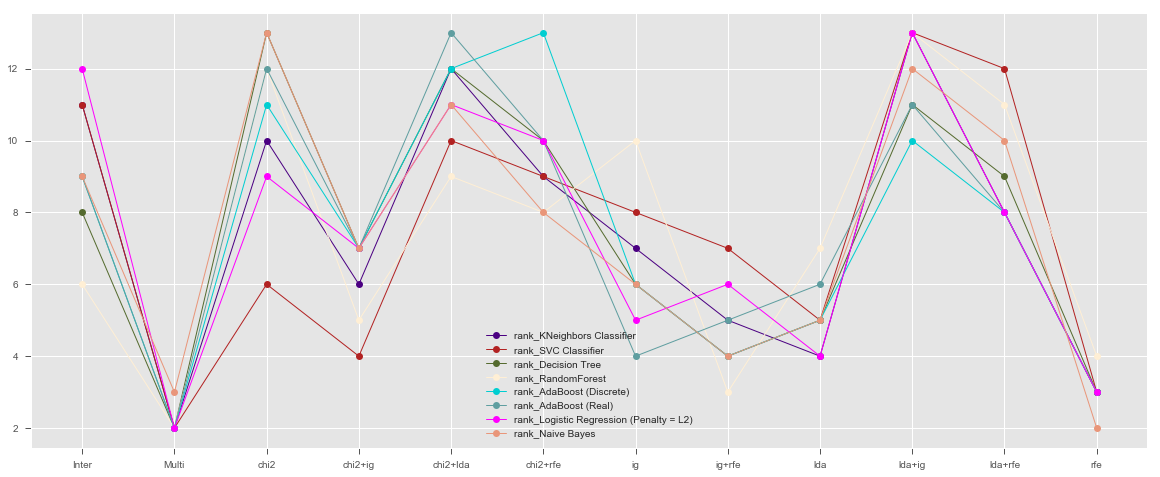

In [123]:
df_rank_per_classifier = generate_df_rank_per_classifier(results_df)
plt.rcParams['figure.figsize'] = (20, 8)
plot_df(df_rank_per_classifier[df_rank_per_classifier.feat_set_id != 'Union'].drop('feat_th', axis = 1))

#### Box Plot: Rank of Feature Selection Algorithm with Respect to the Different Classifiers

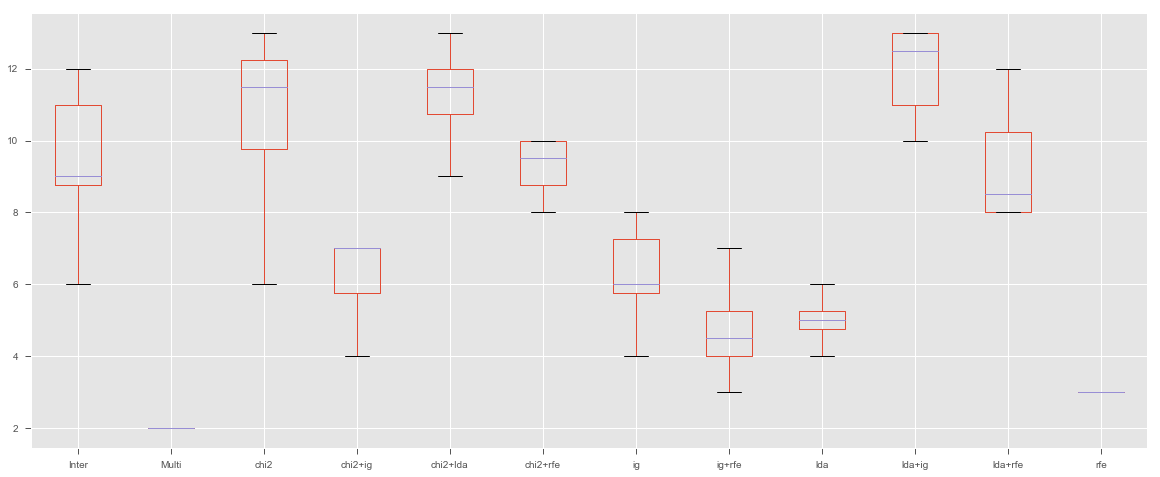

In [124]:
df_rank_per_classifier[df_rank_per_classifier.feat_set_id != 'Union'].drop('feat_th', axis = 1).set_index('feat_set_id').transpose().boxplot()

#### Table With the Mean Rank of Each Feature Selection Algorithm

The highlighted cells are the highest accuracy score per row.

In [66]:
results_accuracy_score_by_ds = display_accuracy_score_table(dataset_df, results_df)
columns_to_delete = ['attr_cnt', 'classes_cnt', 'instances', u'attr_type_integer', 'attr_type_real', 
                     'exec_t_chi2', 'exec_t_lda', 'exec_t_ig', 'exec_t_rfe', 'Union']
results_accuracy_score_by_ds.drop(columns_to_delete, axis=1).style.apply(lambda x: ["background: green" if v == x.max() else "" for v in x], axis = 1)

#### Heat Map Between the Feature Selection Algorithm Accuracy Scores vs Other Dataset Attributes

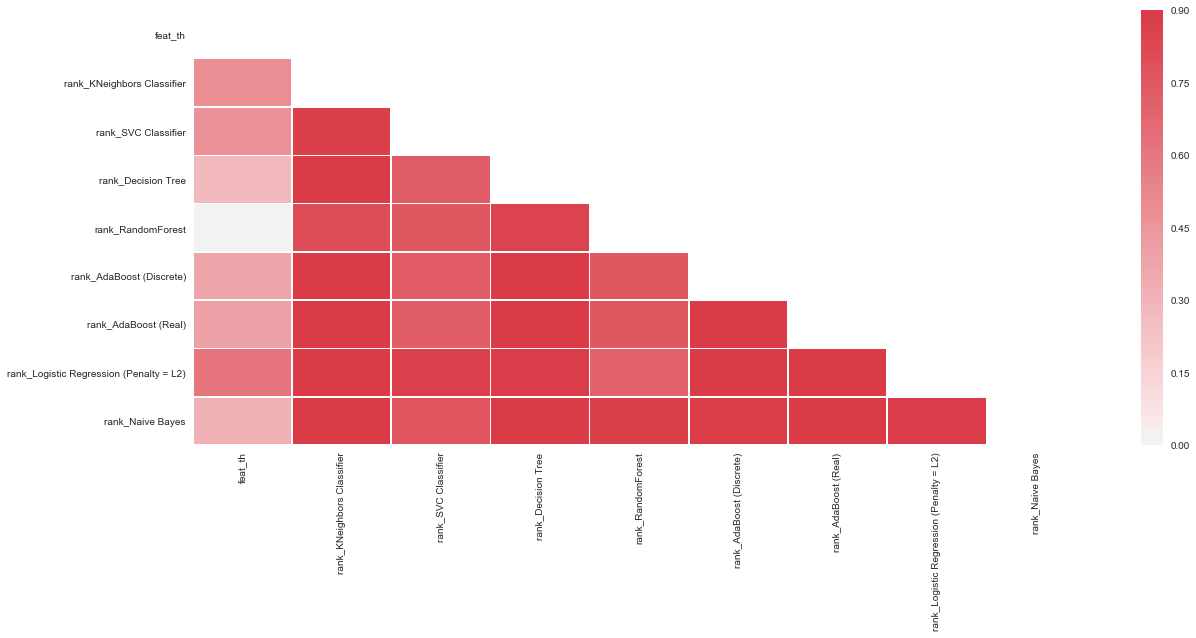

In [128]:
corr = df_rank_per_classifier.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=0, vmax=0.9, linewidths=.5, cmap=cmap, center=0)

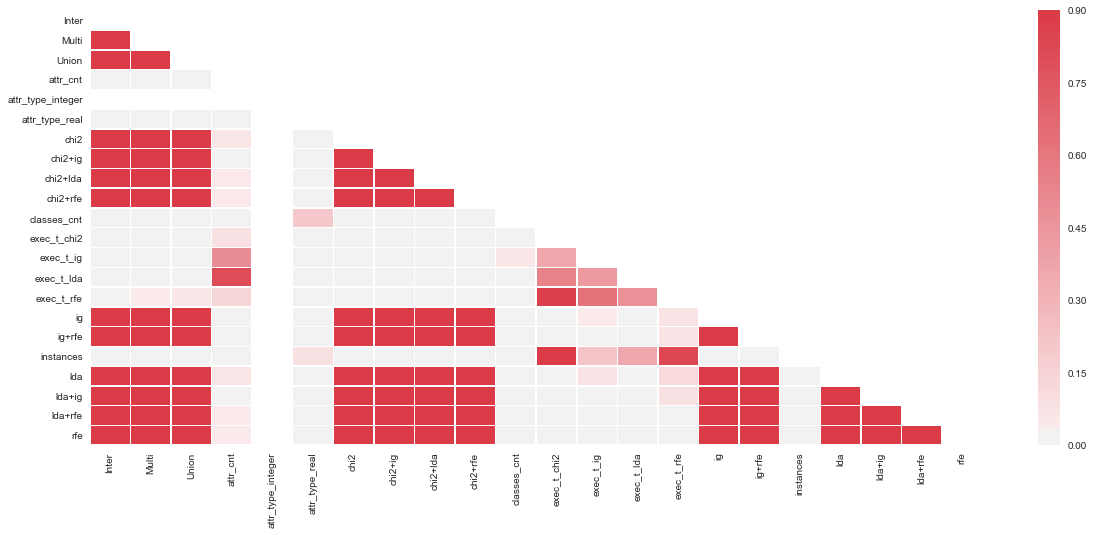

In [127]:
corr = results_accuracy_score_by_ds.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=0, vmax=0.9, linewidths=.5, cmap=cmap, center=0)

### Other Tables

#### Overall Performance Ranking

In [76]:
df_general = results_df.drop('feat_th', axis = 1).groupby(['feat_set_id']).mean().reset_index()
df_general['rank_by_score'] = df_general['accuracy_score'].rank(ascending=False)
df_general = df_general.sort_values(by='rank_by_score').reset_index(drop=True).set_index('feat_set_id')
df_general.index.name = None
df_general

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.674534       0.674650        0.452072  22.648146   
Multi           0.666591       0.674464        0.438962  19.239605   
rfe             0.661103       0.668385        0.428659  26.200876   
ig+rfe          0.656023       0.668787        0.418927  15.683474   
lda             0.654854       0.666213        0.420444  27.199985   
ig              0.652367       0.662531        0.418505  27.274875   
chi2+ig         0.649978       0.669850        0.422860  21.493032   
lda+rfe         0.644888       0.656339        0.398855  18.491042   
Inter           0.643454       0.674470        0.399575  11.478305   
chi2+rfe        0.642605       0.664502        0.409583  19.933689   
chi2+lda        0.641334       0.659719        0.404104  22.814156   
chi2            0.640288       0.664745        0.422530  28.196082   
lda+ig          0.637649       0.672048        0.389377  19.154253   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
ig+rfe              4.0  
lda                 5.0  
ig                  6.0  
chi2+ig             7.0  
lda+rfe             8.0  
Inter               9.0  
chi2+rfe           10.0  
chi2+lda           11.0  
chi2               12.0  
lda+ig             13.0

#### Performance Ranking Per Classifier

In [88]:
def performance_ranking_per_classifier(classifier):
    df_t = results_df[results_df['classifier'] == classifier].drop('feat_th', axis = 1).groupby(['feat_set_id']).mean().reset_index()
    df_t['rank_by_score'] = df_t['accuracy_score'].rank(ascending=False)
    df_t = df_t.sort_values(by='rank_by_score').reset_index(drop=True).set_index('feat_set_id')
    df_t.index.name = None
    return df_t

In [89]:
performance_ranking_per_classifier('Decision Tree')

accuracy_score  geo_score_woz  real_geo_score    exec_t  \
Union           0.668731       0.633869        0.511027  0.114166   
Multi           0.666257       0.627552        0.503971  0.102937   
rfe             0.660119       0.620622        0.480994  0.138569   
ig+rfe          0.655816       0.622271        0.476576  0.089927   
lda             0.654562       0.623763        0.484141  0.148352   
ig              0.651662       0.615109        0.478348  0.143369   
chi2+ig         0.649583       0.626248        0.478947  0.121747   
Inter           0.648328       0.629293        0.453477  0.059797   
lda+rfe         0.645507       0.603215        0.452333  0.101643   
chi2+rfe        0.642327       0.616523        0.458325  0.108648   
lda+ig          0.641631       0.628225        0.455941  0.104307   
chi2+lda        0.641275       0.609017        0.458316  0.119380   
chi2            0.636799       0.617646        0.473064  0.153487   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
ig+rfe              4.0  
lda                 5.0  
ig                  6.0  
chi2+ig             7.0  
Inter               8.0  
lda+rfe             9.0  
chi2+rfe           10.0  
lda+ig             11.0  
chi2+lda           12.0  
chi2               13.0

In [90]:
performance_ranking_per_classifier('KNeighbors Classifier')

accuracy_score  geo_score_woz  real_geo_score    exec_t  \
Union           0.715126       0.662860        0.539660  4.332366   
Multi           0.708411       0.664481        0.530923  2.435787   
rfe             0.706734       0.657438        0.518292  3.292025   
lda             0.697558       0.655274        0.515952  3.609126   
ig+rfe          0.693962       0.661225        0.507603  1.745552   
chi2+ig         0.686294       0.664314        0.505941  3.306392   
ig              0.684529       0.643940        0.505463  6.361848   
lda+rfe         0.684468       0.635371        0.496199  1.555178   
chi2+rfe        0.680157       0.646735        0.494803  2.265443   
chi2            0.678301       0.649579        0.498365  4.871530   
Inter           0.678012       0.661858        0.486734  0.911143   
chi2+lda        0.677561       0.643742        0.492072  2.722727   
lda+ig          0.675494       0.657505        0.486312  1.873642   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
lda                 4.0  
ig+rfe              5.0  
chi2+ig             6.0  
ig                  7.0  
lda+rfe             8.0  
chi2+rfe            9.0  
chi2               10.0  
Inter              11.0  
chi2+lda           12.0  
lda+ig             13.0

In [91]:
performance_ranking_per_classifier('SVC Classifier')

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.636394       0.802938        0.291060  35.603061   
Multi           0.628245       0.808077        0.278873  28.238995   
rfe             0.622556       0.818113        0.272526  41.926060   
chi2+ig         0.622427       0.809366        0.266639  29.620968   
lda             0.621104       0.818196        0.253458  46.457975   
chi2            0.620470       0.805649        0.270818  48.519611   
ig+rfe          0.618383       0.822329        0.259509  18.526096   
ig              0.617304       0.825524        0.264839  43.943545   
chi2+rfe        0.616565       0.805450        0.259257  30.784156   
chi2+lda        0.615475       0.815326        0.243347  33.858814   
Inter           0.611121       0.818521        0.242234  12.784156   
lda+rfe         0.610356       0.823176        0.238573  25.882474   
lda+ig          0.606378       0.826982        0.231239  29.671932   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
chi2+ig             4.0  
lda                 5.0  
chi2                6.0  
ig+rfe              7.0  
ig                  8.0  
chi2+rfe            9.0  
chi2+lda           10.0  
Inter              11.0  
lda+rfe            12.0  
lda+ig             13.0

In [93]:
performance_ranking_per_classifier('RandomForest')

accuracy_score  geo_score_woz  real_geo_score    exec_t  \
Union           0.636212       0.658942        0.290108  0.461116   
Multi           0.631362       0.667898        0.277615  0.461620   
ig+rfe          0.630113       0.659108        0.289285  0.471367   
rfe             0.628459       0.665254        0.292426  0.557016   
chi2+ig         0.623665       0.661316        0.285690  0.563975   
Inter           0.623235       0.667526        0.280253  0.352163   
lda             0.622446       0.643059        0.266461  0.517930   
chi2+rfe        0.621998       0.667199        0.280910  0.512946   
chi2+lda        0.619817       0.649346        0.265258  0.555464   
ig              0.619661       0.658845        0.272402  0.528324   
lda+rfe         0.619110       0.649425        0.266303  0.479400   
chi2            0.616318       0.652975        0.286168  0.540257   
lda+ig          0.608310       0.669086        0.249975  0.488524   

          rank_by_score  
Union               1.0  
Multi               2.0  
ig+rfe              3.0  
rfe                 4.0  
chi2+ig             5.0  
Inter               6.0  
lda                 7.0  
chi2+rfe            8.0  
chi2+lda            9.0  
ig                 10.0  
lda+rfe            11.0  
chi2               12.0  
lda+ig             13.0

In [94]:
performance_ranking_per_classifier('AdaBoost (Discrete)')

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.701694       0.677484        0.510428  65.970440   
Multi           0.686808       0.661870        0.493193  56.192354   
rfe             0.678131       0.651477        0.478275  74.041849   
ig+rfe          0.676917       0.658148        0.471330  46.074875   
lda             0.675427       0.656463        0.480220  75.973495   
ig              0.674903       0.645482        0.473876  76.239963   
chi2+ig         0.667685       0.654142        0.477395  61.489756   
lda+rfe         0.665357       0.635454        0.450973  51.357227   
Inter           0.659609       0.660181        0.437891  31.475798   
lda+ig          0.656595       0.658768        0.441525  52.132266   
chi2            0.653917       0.646628        0.475702  74.386607   
chi2+lda        0.653316       0.638867        0.461556  63.641320   
chi2+rfe        0.650175       0.639140        0.457306  54.270747   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
ig+rfe              4.0  
lda                 5.0  
ig                  6.0  
chi2+ig             7.0  
lda+rfe             8.0  
Inter               9.0  
lda+ig             10.0  
chi2               11.0  
chi2+lda           12.0  
chi2+rfe           13.0

In [95]:
performance_ranking_per_classifier('AdaBoost (Real)')

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.647126       0.621986        0.429241  73.706653   
Multi           0.643008       0.621601        0.428381  65.658049   
rfe             0.632965       0.607421        0.409365  88.558675   
ig              0.629666       0.608502        0.407270  89.859406   
ig+rfe          0.628584       0.603979        0.405505  57.970596   
lda             0.623097       0.609309        0.403728  89.720000   
chi2+ig         0.623034       0.609900        0.411485  76.000439   
lda+rfe         0.614664       0.590752        0.382447  67.841723   
Inter           0.613373       0.612723        0.383139  45.817154   
chi2+rfe        0.612510       0.604181        0.400521  70.775284   
lda+ig          0.611297       0.610273        0.374580  68.234773   
chi2            0.610627       0.605032        0.412660  95.873465   
chi2+lda        0.608420       0.592701        0.396068  80.730455   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
ig                  4.0  
ig+rfe              5.0  
lda                 6.0  
chi2+ig             7.0  
lda+rfe             8.0  
Inter               9.0  
chi2+rfe           10.0  
lda+ig             11.0  
chi2               12.0  
chi2+lda           13.0

In [96]:
performance_ranking_per_classifier('Logistic Regression (Penalty = L2)')

accuracy_score  geo_score_woz  real_geo_score    exec_t  \
Union           0.744019       0.677975        0.497985  0.856525   
Multi           0.727347       0.684804        0.478359  0.694651   
rfe             0.717249       0.678212        0.473521  0.925084   
lda             0.712802       0.671416        0.458003  1.010042   
ig              0.712449       0.670685        0.449027  0.959569   
ig+rfe          0.710039       0.684842        0.451537  0.481056   
chi2+ig         0.703105       0.674120        0.464843  0.694891   
lda+rfe         0.698538       0.675670        0.432842  0.588820   
chi2            0.694984       0.681954        0.469508  1.049773   
chi2+rfe        0.694577       0.683980        0.449672  0.614915   
chi2+lda        0.694432       0.684430        0.444817  0.738237   
Inter           0.692358       0.697323        0.437685  0.341336   
lda+ig          0.685179       0.688066        0.411227  0.596814   

          rank_by_score  
Union               1.0  
Multi               2.0  
rfe                 3.0  
lda                 4.0  
ig                  5.0  
ig+rfe              6.0  
chi2+ig             7.0  
lda+rfe             8.0  
chi2                9.0  
chi2+rfe           10.0  
chi2+lda           11.0  
Inter              12.0  
lda+ig             13.0

In [97]:
performance_ranking_per_classifier('Naive Bayes')

accuracy_score  geo_score_woz  real_geo_score    exec_t  \
Union           0.646969       0.661145        0.547065  0.140838   
rfe             0.642610       0.648538        0.503875  0.167728   
Multi           0.641288       0.659429        0.520381  0.132447   
ig+rfe          0.634368       0.638394        0.490068  0.108325   
lda             0.631831       0.652222        0.501586  0.162957   
ig              0.628759       0.632161        0.496814  0.162977   
chi2+ig         0.624032       0.659395        0.491939  0.146091   
chi2+rfe        0.622529       0.652808        0.475873  0.137374   
Inter           0.621598       0.648337        0.475190  0.084896   
lda+rfe         0.621102       0.637646        0.471168  0.121868   
chi2+lda        0.620377       0.644324        0.471397  0.146852   
lda+ig          0.616305       0.637477        0.464219  0.131762   
chi2            0.610884       0.658494        0.493959  0.173924   

          rank_by_score  
Union               1.0  
rfe                 2.0  
Multi               3.0  
ig+rfe              4.0  
lda                 5.0  
ig                  6.0  
chi2+ig             7.0  
chi2+rfe            8.0  
Inter               9.0  
lda+rfe            10.0  
chi2+lda           11.0  
lda+ig             12.0  
chi2               13.0

In [92]:
results_df.classifier.unique()

array(['KNeighbors Classifier', 'SVC Classifier', 'Decision Tree',
       'RandomForest', 'AdaBoost (Discrete)', 'AdaBoost (Real)',
       'Logistic Regression (Penalty = L2)', 'Naive Bayes'], dtype=object)

#### Performance Ranking Per Threshold

In [102]:
def performance_ranking_per_threshold(min_th, max_th):
    df_t = results_df[(results_df.feat_th > min_th) & (results_df.feat_th < max_th)].drop('feat_th', axis = 1).groupby(['feat_set_id']).mean().reset_index()
    df_t['rank_by_score'] = df_t['accuracy_score'].rank(ascending=False)
    df_t = df_t.sort_values(by='rank_by_score').reset_index(drop=True).set_index('feat_set_id')
    df_t.index.name = None
    return df_t

In [130]:
performance_ranking_per_threshold(0.0, 0.1)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.641058       0.656971        0.399602  18.695143   
ig+rfe          0.594649       0.613088        0.357247  14.383672   
rfe             0.584715       0.633296        0.283011  14.601343   
Multi           0.573019       0.658364        0.282917  11.025078   
chi2+rfe        0.570658       0.664961        0.254671  11.982614   
lda             0.556237       0.632344        0.264250  13.777443   
ig              0.552414       0.634944        0.270778  13.501345   
Inter           0.547776       0.562106        0.345696  12.749220   
lda+ig          0.545588       0.716071        0.214774  13.470656   
chi2+ig         0.534896       0.670139        0.326976  14.351901   
chi2            0.529700       0.652163        0.272059  14.835734   
lda+rfe         0.529255       0.574932        0.218012  12.709368   
chi2+lda        0.501640       0.578015        0.202453  10.648417   

          rank_by_score  
Union               1.0  
ig+rfe              2.0  
rfe                 3.0  
Multi               4.0  
chi2+rfe            5.0  
lda                 6.0  
ig                  7.0  
Inter               8.0  
lda+ig              9.0  
chi2+ig            10.0  
chi2               11.0  
lda+rfe            12.0  
chi2+lda           13.0

In [129]:
performance_ranking_per_threshold(0.1, 0.2)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.667091       0.676085        0.451516  24.447559   
chi2+rfe        0.646472       0.673840        0.368252  11.664827   
rfe             0.632378       0.664363        0.384400  17.616551   
Multi           0.631343       0.678165        0.398252  14.555408   
ig+rfe          0.628684       0.691693        0.364105  11.059268   
Inter           0.628394       0.722926        0.391819  13.073160   
lda             0.624456       0.661306        0.362401  16.739744   
chi2+lda        0.605228       0.690158        0.294053  12.317531   
ig              0.602485       0.644004        0.332475  15.784224   
lda+rfe         0.599984       0.633357        0.322203  12.755812   
chi2            0.587992       0.663289        0.359211  17.009557   
chi2+ig         0.587307       0.674329        0.362295  12.145739   
lda+ig          0.554543       0.641133        0.249429  15.987899   

          rank_by_score  
Union               1.0  
chi2+rfe            2.0  
rfe                 3.0  
Multi               4.0  
ig+rfe              5.0  
Inter               6.0  
lda                 7.0  
chi2+lda            8.0  
ig                  9.0  
lda+rfe            10.0  
chi2               11.0  
chi2+ig            12.0  
lda+ig             13.0

In [105]:
performance_ranking_per_threshold(0.2, 0.3)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.683242       0.679446        0.454897  25.964607   
Multi           0.673924       0.675220        0.442101  17.313590   
lda             0.657246       0.667935        0.412932  18.791868   
rfe             0.649951       0.662022        0.407990  19.030373   
chi2+ig         0.647732       0.677715        0.366542  13.141531   
ig              0.646469       0.644928        0.396867  18.274596   
ig+rfe          0.640042       0.655662        0.357011  11.257071   
chi2            0.618021       0.647887        0.406501  18.904777   
lda+rfe         0.617883       0.642985        0.337823  14.809163   
Inter           0.602852       0.721049        0.287441   9.409963   
chi2+lda        0.601897       0.628572        0.333059  15.752431   
lda+ig          0.595999       0.671294        0.293167  15.197226   
chi2+rfe        0.586334       0.637544        0.326029  15.287176   

          rank_by_score  
Union               1.0  
Multi               2.0  
lda                 3.0  
rfe                 4.0  
chi2+ig             5.0  
ig                  6.0  
ig+rfe              7.0  
chi2                8.0  
lda+rfe             9.0  
Inter              10.0  
chi2+lda           11.0  
lda+ig             12.0  
chi2+rfe           13.0

In [106]:
performance_ranking_per_threshold(0.3, 0.4)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Union           0.685649       0.686168        0.460369  27.075466   
Multi           0.681718       0.678310        0.454399  20.249858   
ig              0.665027       0.665914        0.434922  21.296649   
rfe             0.663726       0.676136        0.417054  21.798640   
lda             0.661992       0.664062        0.421306  21.837506   
ig+rfe          0.648196       0.662352        0.378851  10.915537   
chi2+ig         0.643899       0.654263        0.390401  15.966995   
lda+rfe         0.637608       0.644011        0.369809  16.888913   
lda+ig          0.630629       0.671072        0.362648  15.580746   
chi2+lda        0.627995       0.637319        0.385475  16.667569   
chi2            0.624919       0.656370        0.421390  21.588120   
Inter           0.619380       0.697568        0.299270   8.899271   
chi2+rfe        0.612434       0.652426        0.386160  16.456652   

          rank_by_score  
Union               1.0  
Multi               2.0  
ig                  3.0  
rfe                 4.0  
lda                 5.0  
ig+rfe              6.0  
chi2+ig             7.0  
lda+rfe             8.0  
lda+ig              9.0  
chi2+lda           10.0  
chi2               11.0  
Inter              12.0  
chi2+rfe           13.0

In [107]:
performance_ranking_per_threshold(0.4, 0.5)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Multi           0.672788       0.672199        0.458011  22.800213   
Union           0.671606       0.674282        0.456330  26.594600   
rfe             0.668117       0.674421        0.443898  24.368712   
ig+rfe          0.654210       0.669899        0.410025  14.935490   
ig              0.652016       0.652409        0.426204  25.020046   
lda             0.651829       0.656143        0.431641  25.210126   
lda+rfe         0.643548       0.647752        0.400198  17.564019   
chi2            0.639434       0.647303        0.422692  25.155733   
lda+ig          0.633850       0.664424        0.385792  18.047570   
chi2+rfe        0.633143       0.653849        0.405210  18.093609   
chi2+ig         0.622320       0.640708        0.399735  18.687063   
chi2+lda        0.622286       0.638693        0.396096  19.132951   
Inter           0.591567       0.628440        0.327898  11.794941   

          rank_by_score  
Multi               1.0  
Union               2.0  
rfe                 3.0  
ig+rfe              4.0  
ig                  5.0  
lda                 6.0  
lda+rfe             7.0  
chi2                8.0  
lda+ig              9.0  
chi2+rfe           10.0  
chi2+ig            11.0  
chi2+lda           12.0  
Inter              13.0

In [108]:
performance_ranking_per_threshold(0.6, 0.7)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Multi           0.687250       0.683322        0.462496  21.614517   
Union           0.685087       0.678833        0.455707  24.941421   
ig              0.682156       0.678627        0.461243  31.639484   
chi2            0.679720       0.681638        0.460889  31.255995   
rfe             0.679426       0.674304        0.456489  28.902759   
lda             0.677363       0.679813        0.446964  30.260491   
chi2+ig         0.677304       0.681884        0.460125  21.951574   
lda+rfe         0.676904       0.685991        0.437720  20.632920   
lda+ig          0.675540       0.684080        0.446568  20.630076   
ig+rfe          0.675366       0.677198        0.453403  17.634441   
chi2+lda        0.674022       0.683622        0.450206  25.256692   
Inter           0.673693       0.689328        0.440077  11.086110   
chi2+rfe        0.672643       0.670706        0.452698  21.712480   

          rank_by_score  
Multi               1.0  
Union               2.0  
ig                  3.0  
chi2                4.0  
rfe                 5.0  
lda                 6.0  
chi2+ig             7.0  
lda+rfe             8.0  
lda+ig              9.0  
ig+rfe             10.0  
chi2+lda           11.0  
Inter              12.0  
chi2+rfe           13.0

In [109]:
performance_ranking_per_threshold(0.7, 0.8)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Multi           0.674719       0.672485        0.459270  20.742667   
rfe             0.672517       0.663705        0.457138  31.797158   
ig+rfe          0.671896       0.663198        0.461711  20.276968   
Union           0.669376       0.667453        0.451513  20.417864   
ig              0.666424       0.664672        0.454001  35.918229   
lda+rfe         0.666024       0.668407        0.449223  21.393081   
chi2            0.664174       0.666637        0.453026  35.102754   
lda             0.663906       0.665264        0.453113  33.705063   
chi2+lda        0.662960       0.671659        0.456506  28.293035   
chi2+rfe        0.662815       0.666794        0.458311  23.787441   
lda+ig          0.661759       0.666855        0.451995  22.428429   
chi2+ig         0.661645       0.666153        0.449796  25.351314   
Inter           0.659806       0.670837        0.452530  11.862761   

          rank_by_score  
Multi               1.0  
rfe                 2.0  
ig+rfe              3.0  
Union               4.0  
ig                  5.0  
lda+rfe             6.0  
chi2                7.0  
lda                 8.0  
chi2+lda            9.0  
chi2+rfe           10.0  
lda+ig             11.0  
chi2+ig            12.0  
Inter              13.0

In [110]:
performance_ranking_per_threshold(0.8, 0.9)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
Multi           0.687369       0.684991        0.460635  19.159721   
chi2            0.684128       0.683630        0.459081  39.117011   
lda             0.683924       0.683056        0.457505  36.015300   
chi2+rfe        0.683743       0.683139        0.459760  23.982151   
rfe             0.683404       0.677323        0.458269  33.865159   
Union           0.682870       0.677090        0.458015  17.882407   
lda+rfe         0.682570       0.680353        0.458670  22.470727   
ig              0.682183       0.683417        0.459312  37.206055   
ig+rfe          0.681857       0.678367        0.456455  18.550954   
Inter           0.680857       0.688508        0.452881  11.538200   
chi2+lda        0.680470       0.682616        0.455460  29.731926   
chi2+ig         0.680469       0.684878        0.459683  28.307720   
lda+ig          0.679028       0.680711        0.458444  22.472390   

          rank_by_score  
Multi               1.0  
chi2                2.0  
lda                 3.0  
chi2+rfe            4.0  
rfe                 5.0  
Union               6.0  
lda+rfe             7.0  
ig                  8.0  
ig+rfe              9.0  
Inter              10.0  
chi2+lda           11.0  
chi2+ig            12.0  
lda+ig             13.0

In [111]:
performance_ranking_per_threshold(0.9, 1.0)

accuracy_score  geo_score_woz  real_geo_score     exec_t  \
chi2+rfe        0.687544       0.687027        0.461612  27.729275   
rfe             0.686613       0.683116        0.460034  36.863051   
lda             0.685593       0.682316        0.461147  40.899839   
lda+rfe         0.685329       0.681580        0.457318  19.604909   
Multi           0.685308       0.677122        0.460213  17.797342   
ig+rfe          0.684841       0.681241        0.457909  18.464943   
Inter           0.684723       0.683326        0.461513  12.325927   
lda+ig          0.684261       0.680392        0.455483  22.762604   
chi2+ig         0.684242       0.683819        0.460582  30.920649   
ig              0.683896       0.683085        0.454194  39.421620   
chi2            0.683281       0.681571        0.456866  43.411182   
Union           0.683104       0.678623        0.454265  15.817016   
chi2+lda        0.682857       0.680191        0.456663  33.302348   

          rank_by_score  
chi2+rfe            1.0  
rfe                 2.0  
lda                 3.0  
lda+rfe             4.0  
Multi               5.0  
ig+rfe              6.0  
Inter               7.0  
lda+ig              8.0  
chi2+ig             9.0  
ig                 10.0  
chi2               11.0  
Union              12.0  
chi2+lda           13.0

In [131]:
def performance_ranking_per_classifier(classifier, results_df):
    df_t = results_df[results_df['classifier'] == classifier].drop('feat_th', axis = 1).groupby(['feat_set_id']).mean().reset_index()
    df_t['rank_by_score'] = df_t['accuracy_score'].rank(ascending=False)
    df_t = df_t.sort_values(by='rank_by_score').reset_index(drop=True).set_index('feat_set_id')
    df_t.index.name = None
    return df_t

In [157]:
min_ths = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for classifier in np.sort(results_df.classifier.unique()):
    ascore = []
    for min_th, max_th in zip(min_ths, max_ths):
        df_t = performance_ranking_per_classifier(classifier, results_df[(results_df.feat_th > min_th) & (results_df.feat_th < max_th)])
        ascore.append([max_th, df_t.index[0], df_t['exec_t'][0], df_t['accuracy_score'][0]])
    target = (max([sublist[-1] for sublist in ascore]))
    mean = np.mean([sublist[-1] for sublist in ascore])
    var = np.var([sublist[-1] for sublist in ascore])
    print(classifier, [element for element in ascore if element[-1] == target][0], mean, var)

('AdaBoost (Discrete)', [0.7, 'Union', 67.226828986690151, 0.71925114393709377], 0.70120997756591963, 0.00032897294074674642)
('AdaBoost (Real)', [1.0, 'chi2+rfe', 84.16580184868404, 0.67371202391608898], 0.65162733085585089, 0.00032570395706005056)
('Decision Tree', [0.3, 'Union', 0.12981289625167847, 0.68755029073718377], 0.67612556875094776, 5.9241242656089975e-05)
('KNeighbors Classifier', [0.3, 'Union', 2.8732216074353172, 0.73451802124768106], 0.72159871013642418, 0.00021635623171847385)
('Logistic Regression (Penalty = L2)', [1.0, 'lda+rfe', 0.81247209651129582, 0.76276479373268591], 0.7452208488544263, 0.00034073210165088476)
('Naive Bayes', [0.7, 'lda+ig', 0.14095832336516606, 0.66789973765214916], 0.65457476862867314, 0.00017692293639954708)
('RandomForest', [0.2, 'chi2+rfe', 0.50756475660536027, 0.66463777649482236], 0.64351424178487104, 9.3945959932441095e-05)
('SVC Classifier', [0.7, 'chi2', 53.899646290710997, 0.6531009238115606], 0.63802982105301598, 0.000318753396582058

# Conclusion

The general performance of the union of all the feature selection algorithms (Union) is surprisingly better than the performance of the multi-intersection (Multi). This result somehow contradicts the result in the "Wisdom of Crowd".

However, as we delve deeper, we learned that the threshold has an effect on the performance of Multi. Generally, from 40% to 90% range the Multi performs the best. The result at this threshold level approaches that of the result from the "Wisdom of Crowd", which makes sense. As we approach the 100% threshold, Union essentially becomes Control in the "Wisdom of Crowd" study.

At 100% threshold, the combination of Chi2 and RFE are 